# Available Bluebikes Predictor

My hobby project to predict the number of available bluebikes in 3 stations near my home using historical trip data and weather data

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import os
import pickle
import onnxruntime as rt
# own modules
import get_data

## 1. Extract Data

My data consists of historical Blue Bike trip data and Boston's weather data. Weather data taken from [OpenMeteo](https://open-meteo.com/) and trip data taken from [Blue Bike's system data](https://bluebikes.com/system-data).

### 1.1. Initialization

In [200]:
# init data and download trip data csv files
data_path = './data'

# trip data range
start_year = 2024
end_year = 2025
start_month = 1
end_month = 2
start_date = datetime(start_year, start_month, 1)
end_date = datetime(end_year, end_month, 1)
current_date = start_date

# weather csv filename, need to change date range naming to match the trip data
weather_end_month = end_month + 1 if end_month != 12 else 1
weather_end_year = end_year + 1 if end_month == 12 else end_year
weather_end_date = datetime(weather_end_year, weather_end_month, 1)
weather_csv = f"{start_date.strftime('%Y%m%d')}-{datetime(weather_end_date.year, weather_end_month, 1).strftime('%Y%m%d')}-weather-data.csv"

# time intervals
time_interval = "30min"

### 1.2. Obtaining Weather Data

In [15]:
get_data.get_weather_data(start_year, start_month, end_year, weather_end_month, data_path)

Downloaded weather data: ./data/20240101-20250301-weather-data.csv


In [201]:
weather_df = pd.read_csv(data_path + '/' + weather_csv, skiprows=2)

# rename columns
weather_df = weather_df.rename(columns={
    'temperature_2m (°C)': 'temperature',
    'precipitation (mm)': 'precipitation',
})


# convert time to datetime
weather_df['time'] = pd.to_datetime(weather_df['time'])

# interpolate weather data to intervals
weather_df_interpolated = weather_df.set_index('time').resample(time_interval).interpolate(method="nearest")
# round temperature to int
weather_df_interpolated['temperature'] = weather_df_interpolated['temperature'].round(0)


# reset index
weather_df_interpolated = weather_df_interpolated.reset_index()

# drop end_month, 1, 2025 data
weather_df_interpolated = weather_df_interpolated[weather_df_interpolated['time'].dt.date != datetime(weather_end_year, weather_end_month, 1).date()]


weather_df_interpolated.tail()

,time,temperature,precipitation
20395,2025-02-28 21:30:00,2.0,0.0
20396,2025-02-28 22:00:00,1.0,0.0
20397,2025-02-28 22:30:00,1.0,0.0
20398,2025-02-28 23:00:00,1.0,0.0
20399,2025-02-28 23:30:00,1.0,0.0


Quick Visualization of Weather

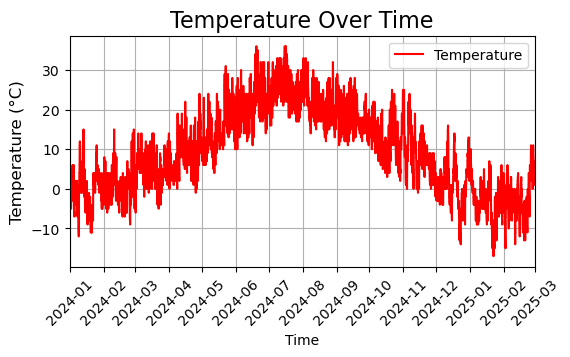

In [177]:
# Plot temperature over time
plt.figure(figsize=(6, 3))
sns.lineplot(x='time', y='temperature', data=weather_df_interpolated, color='red', label='Temperature')
plt.title('Temperature Over Time', fontsize=16)
plt.xlabel('Time', fontsize=10)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.xticks(rotation=45)
plt.xlim(start_date, datetime(end_year, end_month+1,1))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.legend()
plt.grid(visible=True)
plt.show()

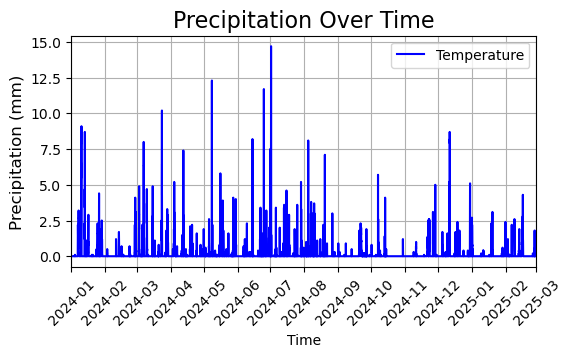

In [52]:
# Plot temperature over time
plt.figure(figsize=(6, 3))
sns.lineplot(x='time', y='precipitation', data=weather_df_interpolated, color='blue', label='Temperature')
plt.title('Precipitation Over Time', fontsize=16)
plt.xlabel('Time', fontsize=10)
plt.ylabel('Precipitation (mm)', fontsize=12)
plt.xticks(rotation=45)
plt.xlim(start_date, datetime(end_year, end_month+1,1))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.legend()
plt.grid(visible=True)
plt.show()

### 1.3. Obtaining Bluebikes Trip Data

In [12]:
get_data.get_bluebikes_trip_data(start_year,start_month,end_year,end_month,data_path)

https://s3.amazonaws.com/hubway-data/202401-bluebikes-tripdata.zip
Downloading: https://s3.amazonaws.com/hubway-data/202401-bluebikes-tripdata.zip
Extracted: 202401-bluebikes-tripdata.csv to ./trip_data
https://s3.amazonaws.com/hubway-data/202402-bluebikes-tripdata.zip
Downloading: https://s3.amazonaws.com/hubway-data/202402-bluebikes-tripdata.zip
Extracted: 202402-bluebikes-tripdata.csv to ./trip_data
https://s3.amazonaws.com/hubway-data/202403-bluebikes-tripdata.zip
Downloading: https://s3.amazonaws.com/hubway-data/202403-bluebikes-tripdata.zip
Extracted: 202403-bluebikes-tripdata.csv to ./trip_data
https://s3.amazonaws.com/hubway-data/202404-bluebikes-tripdata.zip
Downloading: https://s3.amazonaws.com/hubway-data/202404-bluebikes-tripdata.zip
Extracted: 202404-bluebikes-tripdata.csv to ./trip_data
https://s3.amazonaws.com/hubway-data/202405-bluebikes-tripdata.zip
Downloading: https://s3.amazonaws.com/hubway-data/202405-bluebikes-tripdata.zip
Extracted: 202405-bluebikes-tripdata.csv 

In [178]:
# bluebike stations near me
# "A32012" : "Packard's Corner - Commonwealth Ave at Brighton Ave",
# "E32016" : "Commonwealth Ave at Naples Rd",
# "D32035" : "Harvard Ave at Brainerd Rd",
station_ids = ['A32012', 'E32016', 'D32035']

Load and combine trip CSVs into one dataframe

In [179]:
# combine all trip data into one dataframe
data_frames = []

current_date = start_date

while current_date <= end_date:
    file = f"{current_date.strftime('%Y%m')}-bluebikes-tripdata.csv"
    file_path = os.path.join(data_path, file)
    df = pd.read_csv(file_path)
    data_frames.append(df)

    if current_date.month == 12:
            current_date = datetime(current_date.year + 1, 1, 1)
    else:
        current_date = datetime(current_date.year, current_date.month + 1, 1)

trip_data_df = pd.concat(data_frames, ignore_index=True)

## 2. Processing Data

### 2.1. Filtering Bluebikes Trip Data to Relevant Stations

Filter trips to only include stations near my home

In [202]:
# filter trips that start or end at my stations
filtered_trip_data = trip_data_df[trip_data_df['start_station_id'].isin(station_ids) | trip_data_df['end_station_id'].isin(station_ids)].copy()

In [203]:
# remove milliseconds from start and end time
filtered_trip_data.loc[:, 'started_at'] = filtered_trip_data.started_at.str[:16]
filtered_trip_data.loc[:, 'ended_at'] = filtered_trip_data.ended_at.str[:16]

In [204]:
# convert start and end time to datetime
filtered_trip_data['started_at'] = pd.to_datetime(filtered_trip_data.loc[:,'started_at'])
filtered_trip_data['ended_at'] = pd.to_datetime(filtered_trip_data.loc[:,'ended_at'])

# sort by start time
filtered_trip_data.sort_values('started_at', inplace=True)

# remove rideable_type, member_casual columns
filtered_trip_data.drop('rideable_type', axis=1, inplace=True)
filtered_trip_data.drop('member_casual', axis=1, inplace=True)
filtered_trip_data.drop('ride_id', axis=1, inplace=True)


filtered_trip_data.tail()

,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng
4935837,2025-02-28 22:51:00,2025-02-28 23:01:00,B.U. Central - 725 Comm. Ave.,A32003,Packard's Corner - Commonwealth Ave at Brighto...,A32012,42.350406,-71.108279,42.352261,-71.123831
4939651,2025-02-28 23:17:00,2025-02-28 23:22:00,Harvard St and Stedman St,K32017,Harvard Ave at Brainerd Rd,D32035,42.344352,-71.124904,42.349530,-71.130228
4935925,2025-02-28 23:19:00,2025-02-28 23:32:00,MIT Carleton St at Amherst St,M32070,Packard's Corner - Commonwealth Ave at Brighto...,A32012,42.360542,-71.086698,42.352261,-71.123831
4935750,2025-02-28 23:43:00,2025-02-28 23:50:00,Silber Way,D32032,Packard's Corner - Commonwealth Ave at Brighto...,A32012,42.349496,-71.100576,42.352261,-71.123831
4917890,2025-02-28 23:47:00,2025-02-28 23:54:00,Commonwealth Ave at Naples Rd,E32016,Silber Way,D32032,42.351911,-71.123798,42.349496,-71.100576


### 2.2 Aggregate Bluebikes Trip Data

My approach is to calculate the departures and arrivals for each station in set time intervals by rounding trip start and end times.

#### Initialize Dataframe with Time Intervals and Temporal Features

In [205]:
# create df w/ intervals
end_day = 28 if end_month == 2 else 30 if end_month in [4, 6, 9, 11] else 31
start_time = datetime(2024, 1, 1, 0, 0)
end_time = datetime(2025, end_month, end_day, 23, 45)
time_range = pd.date_range(start=start_time, end=end_time, freq=time_interval)

base_df = pd.DataFrame([(time, station) for time in time_range for station in station_ids],
                       columns=["time", "station_id"])

# temporal features
base_df["hour"] = base_df["time"].dt.hour
base_df["minute"] = base_df["time"].dt.minute
base_df["day_of_week"] = base_df["time"].dt.dayofweek  # Mon=0, Tues=1,...,Sun=6
base_df["month"] = base_df["time"].dt.month
base_df["year"] = base_df["time"].dt.year

base_df.head(12)

,time,station_id,hour,minute,day_of_week,month,year
0,2024-01-01 00:00:00,A32012,0,0,0,1,2024
1,2024-01-01 00:00:00,E32016,0,0,0,1,2024
2,2024-01-01 00:00:00,D32035,0,0,0,1,2024
3,2024-01-01 00:30:00,A32012,0,30,0,1,2024
4,2024-01-01 00:30:00,E32016,0,30,0,1,2024
5,2024-01-01 00:30:00,D32035,0,30,0,1,2024
6,2024-01-01 01:00:00,A32012,1,0,0,1,2024
7,2024-01-01 01:00:00,E32016,1,0,0,1,2024
8,2024-01-01 01:00:00,D32035,1,0,0,1,2024
9,2024-01-01 01:30:00,A32012,1,30,0,1,2024


#### Calculate departures and arrivals

For each station, I will calculate the number of departures and arrivals in every 15 minute interval.

In [206]:
# Round trip times to the nearest interval
filtered_trip_data["start_interval"] = filtered_trip_data["started_at"].dt.floor(time_interval)
filtered_trip_data["end_interval"] = filtered_trip_data["ended_at"].dt.floor(time_interval)

# Filter for the specified station IDs
stations_of_interest = ["A32012", "E32016", "D32035"]
filtered_departures = filtered_trip_data[filtered_trip_data["start_station_id"].isin(stations_of_interest)]
filtered_arrivals = filtered_trip_data[filtered_trip_data["end_station_id"].isin(stations_of_interest)]

# Count departures and arrivals for each station and interval
departures = (
    filtered_departures.groupby(["start_interval", "start_station_id"])
    .size()
    .reset_index(name="departures")
    .rename(columns={"start_interval": "time", "start_station_id": "station_id"})
)

arrivals = (
    filtered_arrivals.groupby(["end_interval", "end_station_id"])
    .size()
    .reset_index(name="arrivals")
    .rename(columns={"end_interval": "time", "end_station_id": "station_id"})
)

### 2.3. Merge Bluebikes trip data and weather data

Merging departures, arrivals, temperature, precipitation, and temporal data

In [207]:
# Merge departures and arrivals with the base DataFrame
base_df = base_df.merge(departures, on=["time", "station_id"], how="left")
base_df = base_df.merge(arrivals, on=["time", "station_id"], how="left")

# Fill missing values with 0
base_df["departures"] = base_df["departures"].fillna(0).astype(int)
base_df["arrivals"] = base_df["arrivals"].fillna(0).astype(int)

# merge weather data with base_df
base_df = base_df.merge(weather_df_interpolated, on="time", how="left")

# create a total trips column
base_df['total_trips'] = base_df['departures'] + base_df['arrivals']

In [208]:
print("Total Null Values\n")
print(base_df.isnull().sum())

Total Null Values

time             0
station_id       0
hour             0
minute           0
day_of_week      0
month            0
year             0
departures       0
arrivals         0
temperature      0
precipitation    0
total_trips      0
dtype: int64


In [209]:
base_df.tail(6)

,time,station_id,hour,minute,day_of_week,month,year,departures,arrivals,temperature,precipitation,total_trips
61194,2025-02-28 23:00:00,A32012,23,0,4,2,2025,0,1,1.0,0.0,1
61195,2025-02-28 23:00:00,E32016,23,0,4,2,2025,0,0,1.0,0.0,0
61196,2025-02-28 23:00:00,D32035,23,0,4,2,2025,0,1,1.0,0.0,1
61197,2025-02-28 23:30:00,A32012,23,30,4,2,2025,0,2,1.0,0.0,2
61198,2025-02-28 23:30:00,E32016,23,30,4,2,2025,1,0,1.0,0.0,1
61199,2025-02-28 23:30:00,D32035,23,30,4,2,2025,0,0,1.0,0.0,0


## 3. Exploratory Data Analysis

Below I will do some data inspection and visualization to gain some insights on relationships between different features such as temperature vs trips.

### Analyzing Monthly Trips Pattern

As expected, most bike usage occurs in warmer seasons with more usage around June - October.

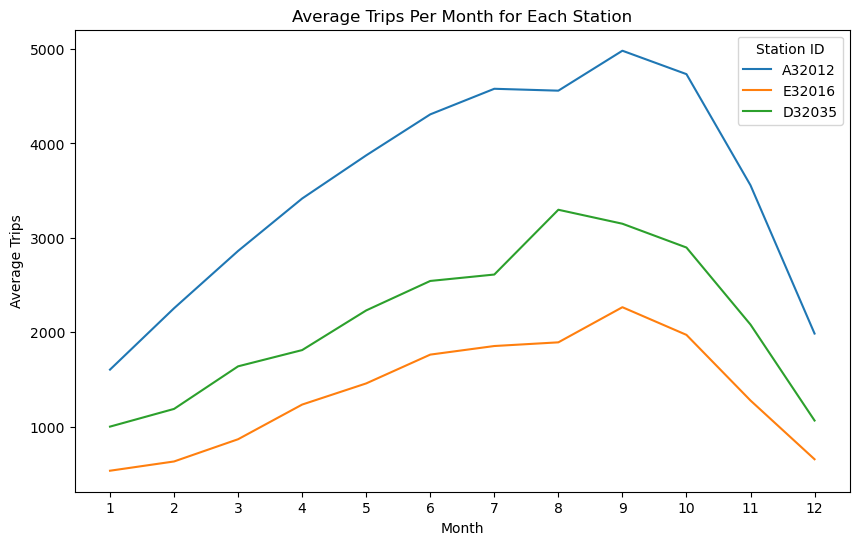

In [166]:
# Group by month and station, sum total trips by month and year first then get average total trips per month
monthly_trips = base_df.groupby(["year","month", "station_id"])["total_trips"].sum().reset_index().groupby(["month","station_id"])["total_trips"].mean().reset_index()

# Plot total trips per month for each station
plt.figure(figsize=(10, 6))
# sns.barplot(data=monthly_trips, x="month", y="total_trips", hue="station_id")
for station in station_ids:
    plt.plot(monthly_trips[monthly_trips["station_id"] == station]["month"], monthly_trips[monthly_trips["station_id"] == station]["total_trips"], label=station)
plt.title("Average Trips Per Month for Each Station")
plt.xlabel("Month")
plt.xticks(range(1, 13))
plt.ylabel("Average Trips")
plt.legend(title="Station ID")
plt.show()


### Anaylzing Popular Days of the Week for Trips

Surpisingly not too much variance between weekends and weekdays.

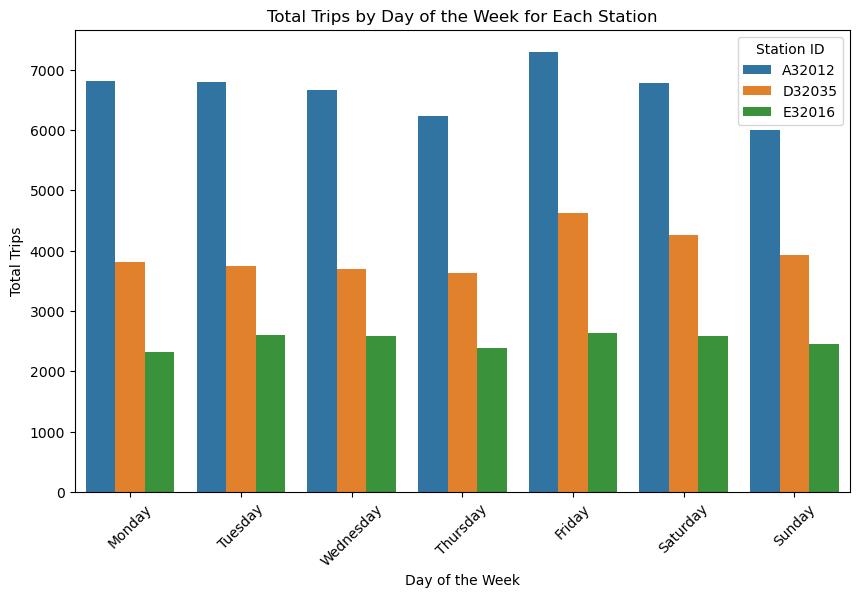

In [64]:
# Group by day of the week and station
weekday_trips = base_df.groupby(["day_of_week", "station_id"])["total_trips"].sum().reset_index()

# Map day_of_week to names for better readability
weekday_mapping = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}
weekday_trips["day_of_week"] = weekday_trips["day_of_week"].map(weekday_mapping)

# Plot average trips by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(data=weekday_trips, x="day_of_week", y="total_trips", hue="station_id")
plt.title("Total Trips by Day of the Week for Each Station")
plt.xlabel("Day of the Week")
plt.ylabel("Total Trips")
plt.legend(title="Station ID")
plt.xticks(rotation=45)
plt.show()

### Analyzing Popular Hours of the Day for Trips

As expected, most trips fall between 8 am to 8 pm. Most usage seems to be around 4-6 pm, which is in-line with what I see in real-life.

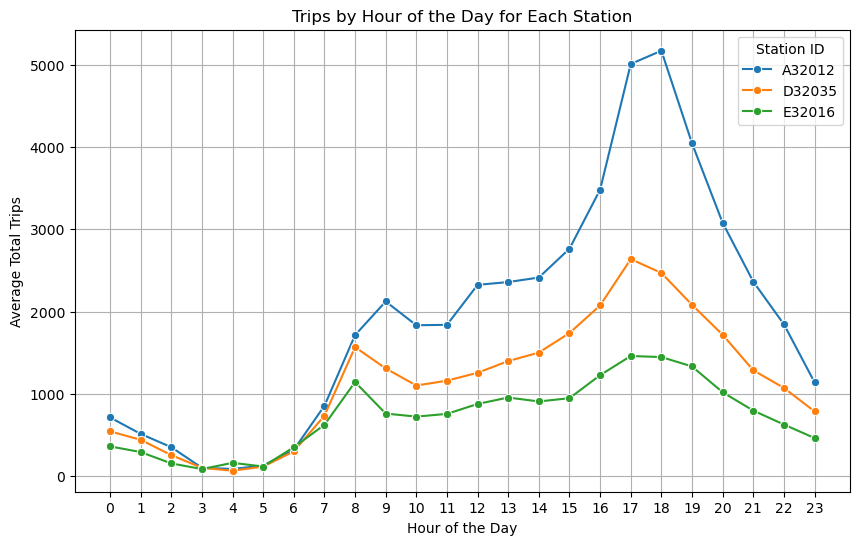

In [167]:
# Group by hour of the day and station
hourly_trips = base_df.groupby(["hour", "station_id"])["total_trips"].sum().reset_index()

# Plot average trips by hour of the day
plt.figure(figsize=(10, 6))
sns.lineplot(data=hourly_trips, x="hour", y="total_trips", hue="station_id", marker="o")
plt.title("Trips by Hour of the Day for Each Station")
plt.xlabel("Hour of the Day")
plt.xticks(range(0, 24))
plt.ylabel("Average Total Trips")
plt.legend(title="Station ID")
plt.grid()
plt.show()

Graphed over the week, it follows a cyclical pattern, maybe I can encode this periodic features somehow later on?

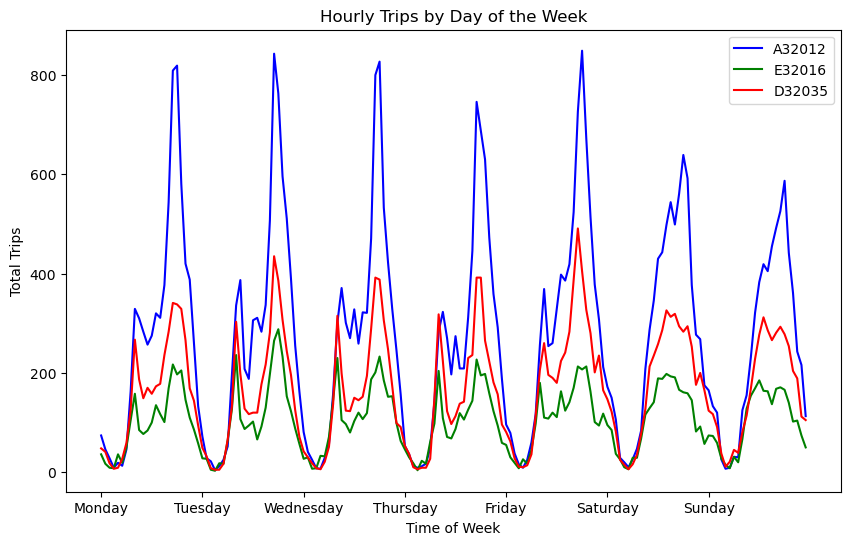

In [168]:
# plot average hourly demand for the week for each station
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title(f"Hourly Trips by Day of the Week")
ax.set_ylabel("Total Trips")
for idx, station_id in enumerate(station_ids):
    hour_week_trips = base_df[base_df["station_id"]==station_id].groupby(["station_id", "day_of_week", "hour"])["total_trips"].sum()
    hour_week_trips.plot(ax=ax, color="bgr"[idx])
    ax.legend(station_ids)
    ax.set_xticks(range(0, 24*7, 24))
    ax.set_xticklabels(weekday_mapping.values())
    ax.set_xlabel("Time of Week")





### Analyzing Temperature vs Total Trips Relationship

As expected, cool to warm weather (~15 - 25 degrees) has more trips than hot or cold weather. 

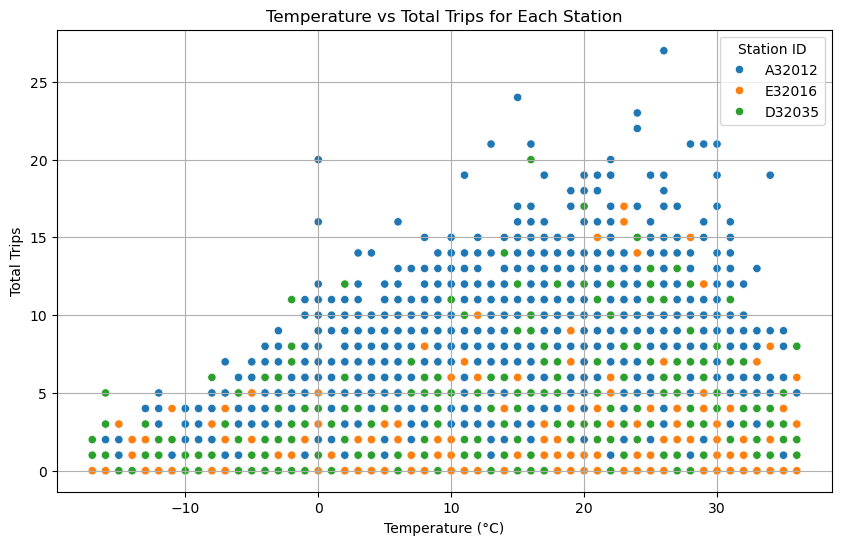

In [67]:
# Plot temperature vs total trips for each station
plt.figure(figsize=(10, 6))
sns.scatterplot(data=base_df, x="temperature", y="total_trips", hue="station_id")
# sns.lineplot(data=base_df, x="temperature", y="total_trips", hue="station_id", marker="o")
plt.title("Temperature vs Total Trips for Each Station")
plt.xlabel("Temperature (°C)")
plt.ylabel("Total Trips")
plt.legend(title="Station ID")
plt.grid()
plt.show()

<Axes: title={'center': 'Temperature vs Total Trips'}, xlabel='Temperature (°C)', ylabel='Average Total Trips'>

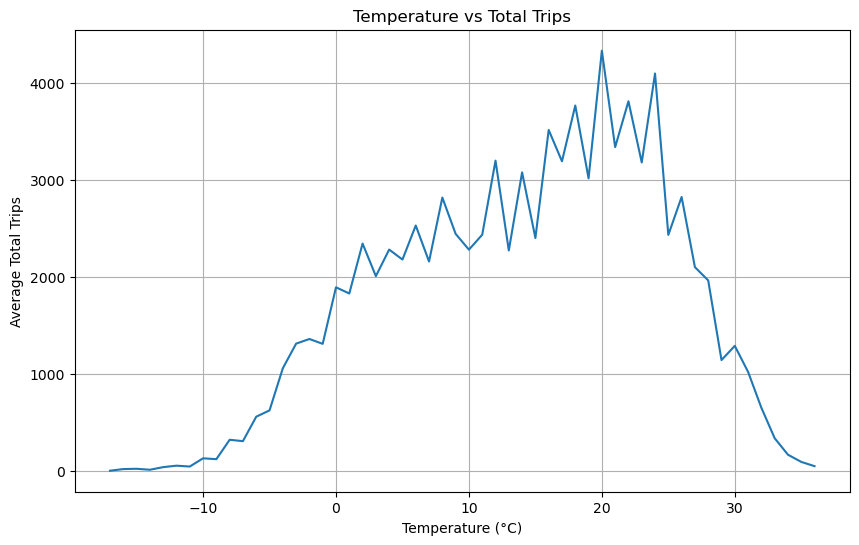

In [68]:
fig, ax = plt.subplots(figsize=(10, 6))
base_df.groupby(["temperature"])["total_trips"].sum().reset_index().plot(ax=ax,x="temperature", y="total_trips", title="Temperature vs Total Trips", legend=False, ylabel="Average Total Trips", xlabel="Temperature (°C)", grid=True)

### Analyzing Precipitation vs Total Trips Relationship

As expected, there are more trips with lower precipitation.

In [32]:
# # Plot precipitation vs total trips for each station
# fig, ax = plt.subplots(3,1, figsize=(10, 16))

# for idx, station in enumerate(station_ids):
#     precipitation_trips = base_df[base_df["station_id"]==station].groupby(["precipitation"])["total_trips"].sum().reset_index()
#     sns.lineplot(data=precipitation_trips, x="precipitation", y="total_trips", ax=ax[idx])
#     ax[idx].set_title(f"Precipitation vs Total Trips for {station}")
#     ax[idx].set_xlabel("Precipitation (mm)")
#     ax[idx].set_ylabel("Total Trips")

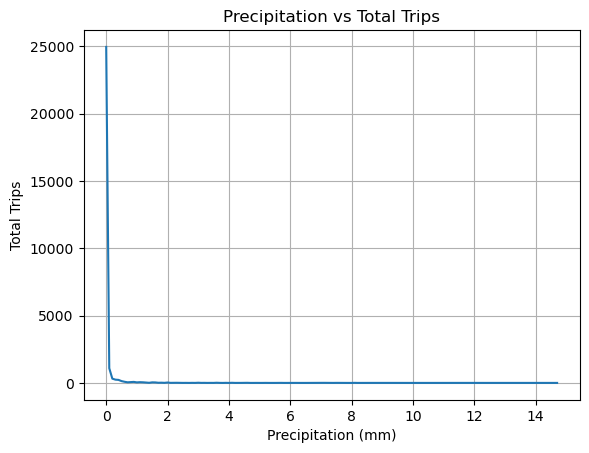

In [188]:
precipitation_trips = base_df[base_df["station_id"]==station].groupby(["precipitation"])["total_trips"].sum().plot(x="precipitation", y="total_trips", title="Precipitation vs Total Trips", legend=False, ylabel="Total Trips", xlabel="Precipitation (mm)", grid=True)

## 4. Building ML Prediction Models

In [210]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_validate
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

### 4.1. Setup

Since the data is a time series dataset, the test data must occur after the training data, meaning that `TimeSeriesSplit` needs to be used instead to split training and testing data.

In [211]:
# split data by station
station_data = {station_id: base_df[base_df["station_id"] == station_id] for station_id in station_ids}

# initialize time series split, used for gradient boosting models
ts_cv = TimeSeriesSplit(
    n_splits=5,
    # gap=48,
    # max_train_size=10000,
    # test_size=1000,
)

save_model_path = './models'

Then setup time-based cross-validation splits to evaluate model, I calculate the MAE and R^2 as a percentage of the maximum value of the target variable instead of the mean 

In [192]:
def evaluate(model, X, y, cv, model_prop=None, model_step=None):
    """ 
    Evaluate the model using cross-validation.
    """
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
        return_estimator=model_prop is not None,
    )
    if model_prop is not None:
        if model_step is not None:
            values = [
                getattr(m[model_step], model_prop) for m in cv_results["estimator"]
            ]
        else:
            values = [getattr(m, model_prop) for m in cv_results["estimator"]]
        print(f"Mean model.{model_prop} = {np.mean(values)}")
    # mae = -cv_results["test_neg_mean_absolute_error"]
    # rmse = -cv_results["test_neg_root_mean_squared_error"]
    # print(
    #     f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
    #     f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    # )
    return cv_results

### 4.2. Baseline Linear Regression Model

I'll use a basic linear regression to act as my baseline model.

In [193]:
print("Linear Regression Model for Arrivals")

alphas = np.logspace(-6, 6, 25)
one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

for station in station_ids:
    print(f"Station {station}")
    X = station_data[station][["hour", "day_of_week", "month", "temperature", "precipitation"]]
    y = station_data[station]["arrivals"] / station_data[station]["arrivals"].max()
    model = LinearRegression()
    cv_results = evaluate(model, X, y, cv=ts_cv)
    mae = -cv_results["test_neg_mean_absolute_error"] / y.max()
    rmse = -cv_results["test_neg_root_mean_squared_error"] / y.max()
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

print("\nLinear Regression Model for Departures")

for station in station_ids:
    print(f"Station {station}")
    X = station_data[station][["hour", "day_of_week", "month", "temperature", "precipitation"]]
    y = station_data[station]["departures"] / station_data[station]["departures"].max()
    model = LinearRegression()
    cv_results = evaluate(model, X, y, cv=ts_cv)
    mae = -cv_results["test_neg_mean_absolute_error"] / y.max()
    rmse = -cv_results["test_neg_root_mean_squared_error"] / y.max()
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

Linear Regression Model for Arrivals
Station A32012
Mean Absolute Error:     0.050 +/- 0.009
Root Mean Squared Error: 0.072 +/- 0.016
Station E32016
Mean Absolute Error:     0.030 +/- 0.009
Root Mean Squared Error: 0.046 +/- 0.011
Station D32035
Mean Absolute Error:     0.038 +/- 0.008
Root Mean Squared Error: 0.054 +/- 0.012

Linear Regression Model for Departures
Station A32012
Mean Absolute Error:     0.043 +/- 0.009
Root Mean Squared Error: 0.059 +/- 0.012
Station E32016
Mean Absolute Error:     0.043 +/- 0.014
Root Mean Squared Error: 0.064 +/- 0.015
Station D32035
Mean Absolute Error:     0.057 +/- 0.014
Root Mean Squared Error: 0.079 +/- 0.018


### 4.3. Gradient Boosting Regression

Below I use a Gradient Boosting Regression with decision trees, `HistGradientBoostingRegressor` to try and improve performance.

In [212]:
print("Gradient Boosting Regressor for Arrivals\n")
for station in station_ids:
    X = station_data[station][["month", "day_of_week", "hour", "minute", "temperature", "precipitation"]]
    y = station_data[station]["arrivals"]

    gbrt = HistGradientBoostingRegressor(random_state=42)
    gbrt.fit(X, y)
    print(f"Station {station}")
    cv_results = evaluate(gbrt, X, y, cv=ts_cv)
    mae = -cv_results["test_neg_mean_absolute_error"] / y.max()
    rmse = -cv_results["test_neg_root_mean_squared_error"] / y.max()
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )
    print()
    pickle.dump(gbrt, open(f"{save_model_path}/{station}_arrivals_gb_model.pkl", "wb"))


Gradient Boosting Regressor for Arrivals

Station A32012
Mean Absolute Error:     0.039 +/- 0.007
Root Mean Squared Error: 0.060 +/- 0.012

Station E32016
Mean Absolute Error:     0.031 +/- 0.008
Root Mean Squared Error: 0.049 +/- 0.012

Station D32035
Mean Absolute Error:     0.042 +/- 0.008
Root Mean Squared Error: 0.062 +/- 0.013



In [213]:
print("Gradient Boosting Regressor for Departures\n")
for station in station_ids:
    X = station_data[station][["month", "day_of_week", "hour", "minute", "temperature", "precipitation"]]
    y = station_data[station]["departures"]

    gbrt = HistGradientBoostingRegressor(random_state=42)
    gbrt.fit(X, y)
    print(f"Station {station}")
    cv_results = evaluate(gbrt, X, y, cv=ts_cv)
    mae = -cv_results["test_neg_mean_absolute_error"] / y.max()
    rmse = -cv_results["test_neg_root_mean_squared_error"] / y.max()
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )
    print()
    pickle.dump(gbrt, open(f"{save_model_path}/{station}_departures_gb_model.pkl", "wb"))


Gradient Boosting Regressor for Departures

Station A32012
Mean Absolute Error:     0.052 +/- 0.010
Root Mean Squared Error: 0.073 +/- 0.014

Station E32016
Mean Absolute Error:     0.056 +/- 0.014
Root Mean Squared Error: 0.083 +/- 0.021

Station D32035
Mean Absolute Error:     0.070 +/- 0.013
Root Mean Squared Error: 0.102 +/- 0.021

